<a href="https://colab.research.google.com/github/FLCL4LIFE/Work-Done-in-Classes/blob/main/tree_nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [10]:
import datetime
from graphviz import Digraph

class UserNode:
    def __init__(self, user_id, is_active, data, last_activity):
        self.user_id = user_id
        self.is_active = is_active
        self.data = data
        self.last_activity = last_activity  # Timestamp of the last activity
        self.children = []

class UserTree:
    def __init__(self):
        self.root = None
        self.archive = []  # List to store archived nodes

    def add_user(self, user_node, parent_node=None):
        if self.root is None:
            self.root = user_node
        else:
            parent_node.children.append(user_node)

    def archive_inactive_users(self, node=None, inactive_period_days=365):
        if node is None:
            node = self.root

        current_time = datetime.datetime.now()
        inactive_period = datetime.timedelta(days=inactive_period_days)

        for child in node.children[:]:  # Make a copy of the list to avoid modification during iteration
            self.archive_inactive_users(child, inactive_period_days)

        if not node.is_active:
            last_active_date = node.last_activity
            if current_time - last_active_date > inactive_period:
                self.archive.append(node)
                if node in self.root.children:
                    self.root.children.remove(node)
                else:
                    for parent in self.root.children:
                        if node in parent.children:
                            parent.children.remove(node)

    def visualize_tree(self, node=None, graph=None, parent_id=None):
        if graph is None:
            graph = Digraph()
            graph.attr('node', shape='circle')
            node = self.root

        if node:
            node_id = str(node.user_id)
            graph.node(node_id, f'{node.user_id}\n{"Active" if node.is_active else "Inactive"}')

            if parent_id:
                graph.edge(parent_id, node_id)

            for child in node.children:
                self.visualize_tree(child, graph, node_id)

        return graph

    def visualize_archived(self):
        graph = Digraph()
        graph.attr('node', shape='circle', style='filled', color='lightgrey')
        for node in self.archive:
            graph.node(f'{node.user_id}', f'{node.user_id}')

        return graph

# Example Usage
tree = UserTree()
current_time = datetime.datetime.now()

# Adding users
root_user = UserNode(1, True, "Root User Data", current_time)

active_users = [
    UserNode(2, True, "Active User 2", current_time),
    UserNode(3, True, "Active User 3", current_time),
    UserNode(4, True, "Active User 4", current_time),
    UserNode(5, True, "Active User 5", current_time),
    UserNode(6, True, "Active User 6", current_time),
    UserNode(7, True, "Active User 7", current_time),
    UserNode(8, True, "Active User 8", current_time),
    UserNode(9, True, "Active User 9", current_time),
    UserNode(10, True, "Active User 10", current_time),
    UserNode(11, True, "Active User 11", current_time)
]

inactive_users = [
    UserNode(12, False, "Inactive User 12", current_time - datetime.timedelta(days=400)),
    UserNode(13, False, "Inactive User 13", current_time - datetime.timedelta(days=500)),
    UserNode(14, False, "Inactive User 14", current_time - datetime.timedelta(days=600)),
    UserNode(15, False, "Inactive User 15", current_time - datetime.timedelta(days=700)),
    UserNode(16, False, "Inactive User 16", current_time - datetime.timedelta(days=800))
]

# Build tree structure
tree.add_user(root_user)
for user in active_users:
    tree.add_user(user, root_user)
for user in inactive_users:
    tree.add_user(user, active_users[0])  # Adding inactive users under one active user for demonstration

# Visualize the tree before archiving
tree_graph = tree.visualize_tree()
tree_graph.render('tree_before_archiving', format='png', cleanup=True)

# Archive inactive users who have been inactive for more than a year (365 days)
tree.archive_inactive_users(inactive_period_days=365)

# Visualize the tree after archiving
tree_graph_after = tree.visualize_tree()
tree_graph_after.render('tree_after_archiving', format='png', cleanup=True)

# Visualize archived nodes
archived_graph = tree.visualize_archived()
archived_graph.render('archived_nodes', format='png', cleanup=True)


'archived_nodes.png'

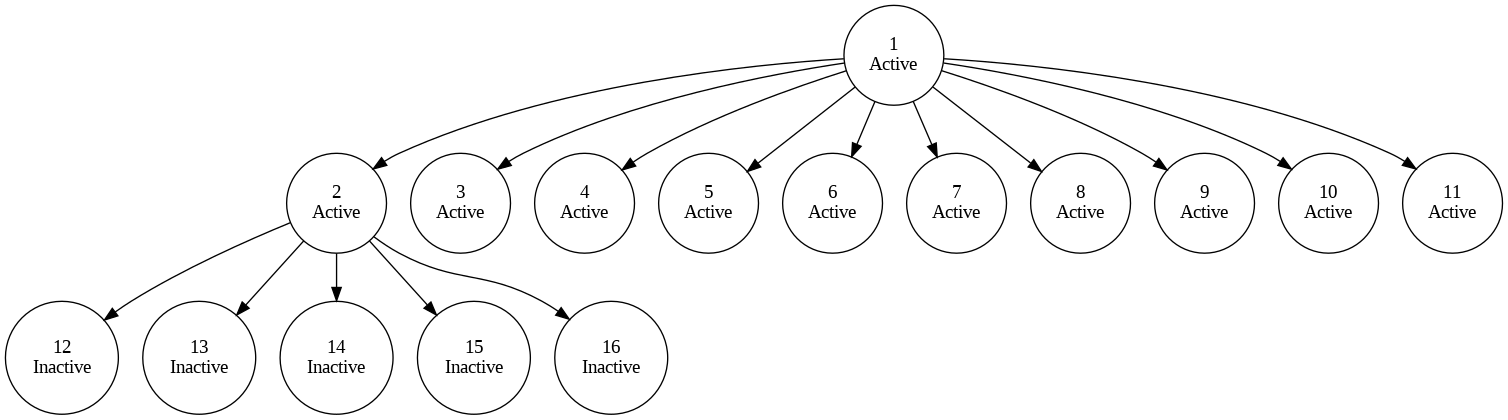

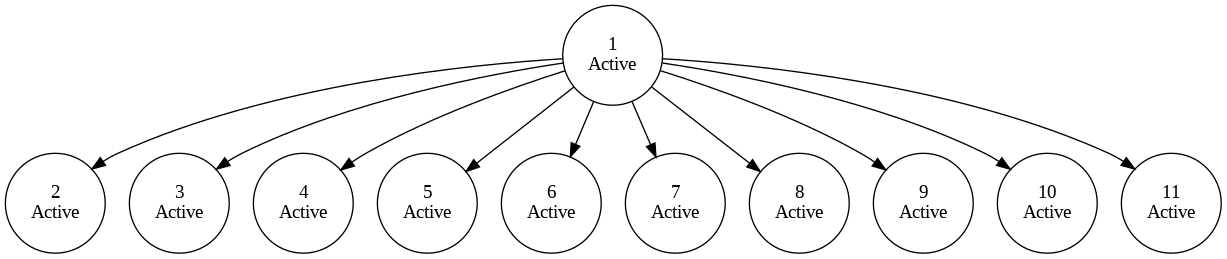

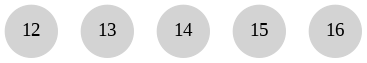

In [11]:
from IPython.display import Image

# Display the tree before archiving
display(Image('tree_before_archiving.png'))

# Display the tree after archiving
display(Image('tree_after_archiving.png'))

# Display archived nodes
display(Image('archived_nodes.png'))
